# Portfolio Optimization: Low Risk vs High Risk

This notebook analyzes and compares two distinct portfolio strategies:

- **Low-Risk Portfolio**: Diversified with bonds, gold, and defensive equities.
- **High-Risk Portfolio**: Focused on high-volatility, growth-oriented tech assets.

Both portfolios are optimized using historical data to balance returns and volatility, and constructed under realistic allocation constraints.


In [2]:
#Import Packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.optimize import minimize
import datetime as dt
sns.set_style('darkgrid')

import yfinance as yf

## Low-Risk Portfolio

**Assets Selected**:
- `VOO` – Vanguard S&P 500 ETF
- `BND` – Vanguard Total Bond Market ETF
- `SHY` – iShares 1-3 Year Treasury Bond ETF
- `XLP` – Consumer Staples Sector ETF
- `GLD` – SPDR Gold Shares

### Justification:
- **Diverse asset classes**: equity, short/long bonds, gold, defensives.
- **Low correlations**: Promotes risk reduction.
- **Stable return potential**: Emphasis on capital preservation with moderate growth.
- **A very conservative portfolio**
- **Low-pair wise correlations (as we show below by calculating the covariance matrix)**


In [3]:
#load data for Vanguard S&P 500 , Vanguard Total Bond Market, iShares, Consumer Staples Select Sector , SPDR Gold Shares  
tickers = ["VOO", "BND", "SHY", "XLP", "GLD"]

start_date = dt.datetime.today()-dt.timedelta(days = 3*365)
end_date = dt.datetime.today()

stock = yf.download(tickers, start = start_date, end = end_date)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  5 of 5 completed


**We estimate colatilities and correlations from the most recent three years of daily prices. Three years provide ~ 750 observations, enough to stabilise the covariance matrix for optimization , yet recent enough to capture the post- pandemic bear market, the 2023-24 equity rebound, and  the current higher-rate environment. A one-year window proved too noisy, while a five year window diluted today's dynamics with pre-COVID zero-rate behaviour. Thus, the three year horizon offers the best trade-off between statistical reliability and regime relevance for a low-risk portfolio built for the coming year**

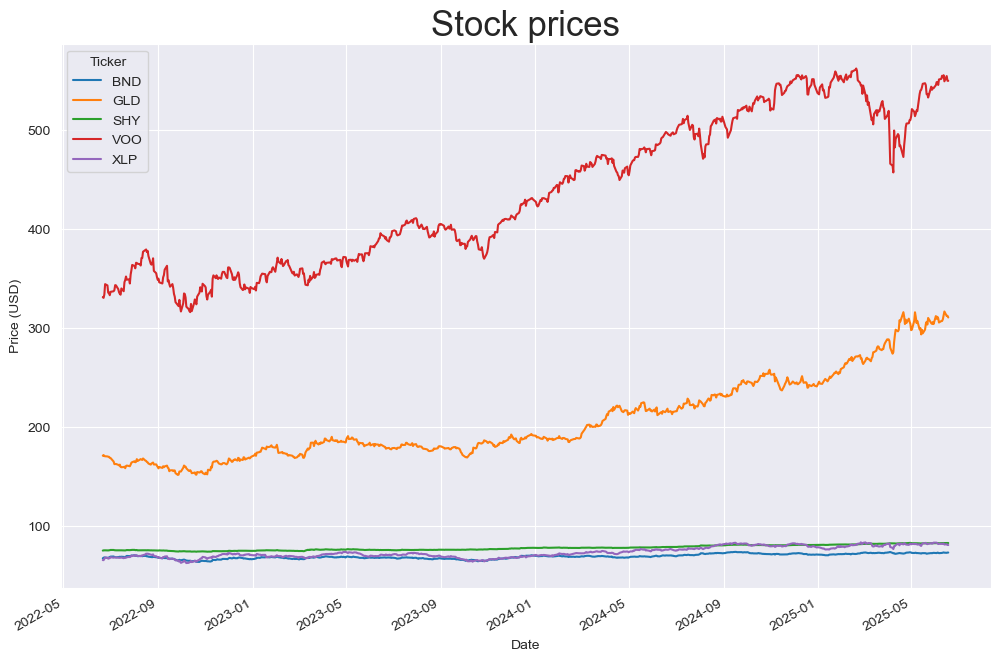

In [4]:
#Plot stocks together 
stock['Close'].plot(figsize=(12,8))
plt.title(f'Stock prices',size=25)
plt.ylabel('Price (USD)')
plt.show()

In [5]:
#Add in column to stock data that is cumulative returns of the stocks

# Step 1: Compute cumulative return from 'Close' prices
close = stock['Close'] 
normalized_returns = close/close.iloc[0]-1 # Moves stock prices to a start of 0

# Step 2: Create MultiIndex columns for new data
normalized_returns.columns = pd.MultiIndex.from_product([['Cumulative Returns'], normalized_returns.columns])

# Step 3: Concatenate to the original DataFrame
stock=pd.concat([stock,normalized_returns],axis=1)


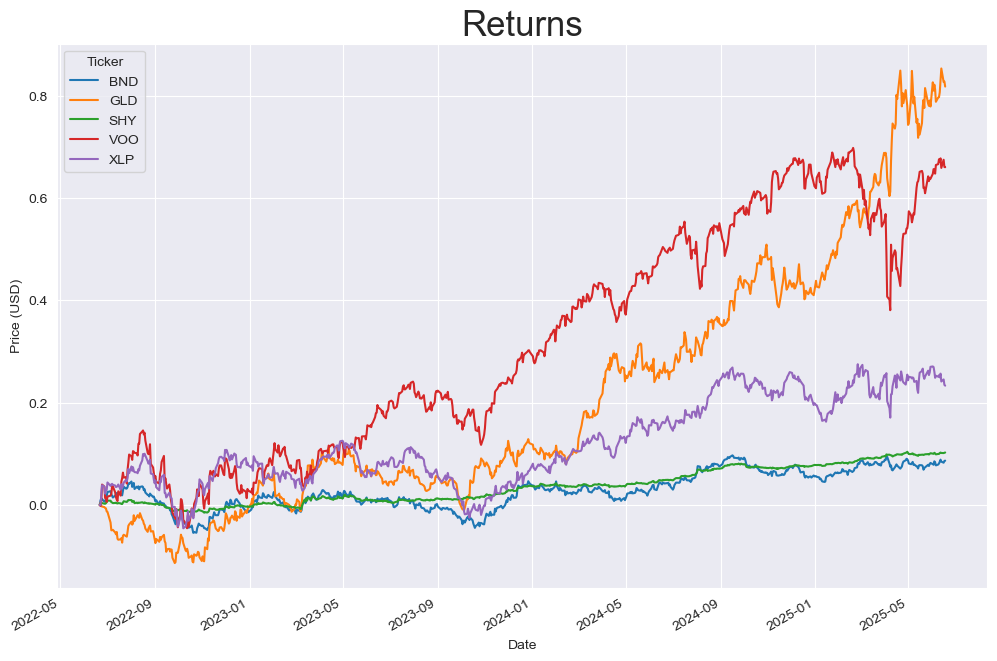

In [6]:
#Plot Cumlative Returns together
stock['Cumulative Returns'].plot(figsize=(12,8))
plt.title(f'Returns',size=25)
plt.ylabel('Price (USD)')
plt.show()


In [8]:
#Create a dataframe of daily returns
#It is quite common to take the logs of daily returns to lessen computational complexity in standard deviation
daily_returns = np.log(stock['Close']/stock['Close'].shift(1))
daily_returns=daily_returns.dropna()


#Create a dictionary of standard deviations of daily return
#Normalize the standard deviation for yearly by multiplying by sqrt(#trading days in year ~ 252)
annualized_volatility = {ticker: np.std(daily_returns[ticker])*np.sqrt(252) for ticker in tickers}
annualized_volatility

{'VOO': 0.17224185801094333,
 'BND': 0.06660306669949298,
 'SHY': 0.02225405982569612,
 'XLP': 0.12758397432441085,
 'GLD': 0.1542747332134756}

**The individual volatilties quantify exactly why each ETF was chosen** 

- **SHY , BND : These are the 'shock-absorbers'. Prices barely move , so they soak up day-to-day bumps. Low-equity correlations and modest daily swings keep the whole portfolio steady.**

- **VOO : Mild growth gear. Add long-run upside, but is capped by the optimiser (see below) so it cannot dominate risk.**

- **XLP: Defensive equity play. Historically fall less than the market in draw-downs, so they give equity exposure with a safety cushion.**

- **GLD : Real asset hedge. Tends to hold value or rise when equities wobble, providing an inflation / crisis hedge.**

In [9]:
# Calculate the covariance matrix
covariance_matrix = 252*((daily_returns).cov())
covariance_matrix

Ticker,BND,GLD,SHY,VOO,XLP
Ticker,,,,,
BND,0.004442,0.003848,0.001222,0.002546,0.002305
GLD,0.003848,0.023832,0.001464,0.004747,0.003543
SHY,0.001222,0.001464,0.000496,0.000267,0.000501
VOO,0.002546,0.004747,0.000267,0.029707,0.012355
XLP,0.002305,0.003543,0.000501,0.012355,0.016299


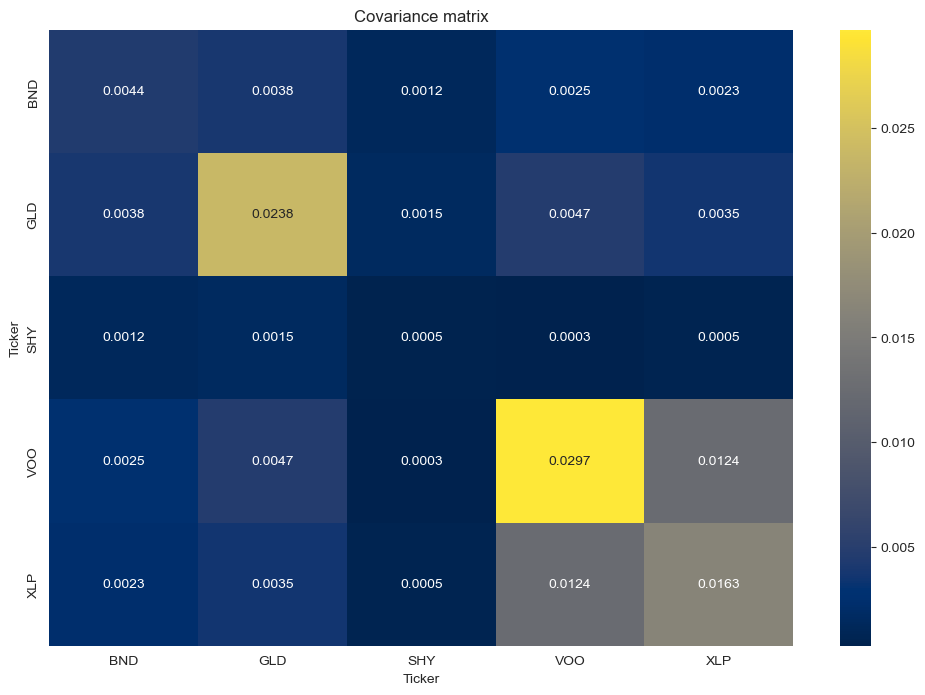

In [10]:
# Create a heatmap to visualize the covariance matrix
plt.figure(figsize=(12,8))
sns.heatmap(covariance_matrix,annot=True,cmap='cividis',fmt='.4f')
plt.title('Covariance matrix')
plt.show()

**Why "Small correaltions" flag a genuinely low-risk portfolio**

- **The volatility of the portfolio is directly proportional to the covariance matrix, and hence is minimized when the correaltions are small**

- **Intuition: independent shocks cancel out. When Asset A is having a bad day, Asset B is not systematically having the same bad day. Gains and losses therefore offset each other inside the portfolio’s daily Profit and Loss.**

**We diversify our portfolio with 5%/40% as the upper and lower bounds**

- **Diversification floor (5%) : With 5 ETFs the smallest holding is still large enough to matter , soth optimiser cannot dump an asset to 0 % just because it's past volatility ticked up**

- **Concentration cap (40 %) : prevents one ETF (say, short-term bonds ) from swallowing > 50% of the portfolio , which would make the whole portfolio behave like one single assset. This also prevents the equity from dampening too much**


In [12]:
#Find a set of weights, equivalently portfolio investment percentages in tickers, 
#which minimizes a historical portfolio's volatility subject to the following investment constraints
#1) Must invest at least 5% of capital into each index
#2) Cannot invest more than 40% of capital into a single index

#Create dictionary average/expected daily return for indexes in stock_symbols normalized for yearly return
#expected_returns = {stock: 252*np.mean(returns[stock]) for stock in stock_symbols}


# Number of assets
n_assets = len(tickers)

# Define an initial guess for asset weights (e.g., equal weights)
initial_weights = np.array([1/n_assets]*n_assets)

# Define weight constraints
#Sum of weights equals 1 
#Allocate at least 5% of capital into each index in stock_symbols
#Do not allocate more than 40% of capital into each index in stock_symbol
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights)-1},
               {'type':'ineq','fun': lambda weights: min(weights)-0.05},
               {'type':'ineq','fun': lambda weights: .40 - max(weights)})

# Define the objective function to minimize portfolio variance
def portfolio_volatility(weights):
    portfolio_std_dev = np.sqrt(np.dot(weights.T,np.dot(covariance_matrix,weights)))
    return portfolio_std_dev

# Run the optimization to find the optimal weights
result = minimize(portfolio_volatility,initial_weights,constraints=constraints)

# Optimal asset weights
optimal_weights = result.x
optimal_vol = result.fun

# Print the optimal weights and expected returns

    
#Print estimated optimal volatility subject to the constraints
print(f'The optimal volatility subject to constraints is {result.fun}')
print(f'The optimal weights are {optimal_weights}')

The optimal volatility subject to constraints is 0.04701182276011781
The optimal weights are [0.39999999 0.05       0.4        0.04999965 0.10000036]


**Above , subject to chosen weight constratints we minimize the annualised voaltility of the portfolio**

**The optimiser maxed out the two calmest, least-correlated bond ETFs at 40 % each, left the highest-volatility equities at their 5 % minima, and gave a modest 10 % to defensive staples; that mix slashes annualised volatility to ≈ 4.8 %—barely a quarter of the broad market—while still preserving a diversified, fully invested portfolio.**

## High-Risk Portfolio

**Assets Selected**:
- `TSLA` - Tesla
- `NVDA` – NVIDIA
- `QQQ` –  Invesco QQQ Trust
- `AMD` – Advanced Micro Devices 
- `META` – Meta Platforms Inc.

### Justification:
- **High-growth potential**: Focus on innovation, AI, semiconductors, and digital platforms.
- **Accepts higher volatility**: to target maximum expected return.
- **Some internal diversification**: via QQQ, which smooths single-stock risk.


In [13]:
high_tickers = ['TSLA','NVDA','QQQ','AMD','META']

high_start_date = dt.datetime.today()-dt.timedelta(days=3*365)
high_end_date=dt.datetime.today()

high_stock=yf.download(high_tickers,start=high_start_date,end=high_end_date)

[*********************100%***********************]  5 of 5 completed


**Why these specific stocks ?**

- **TSLA - Known for extreme price movements and high beta. Represents disruptive innovation in electric vehicles and energy. Significant speculative interest and volatility.**

- **NVDA - A leading semiconductor and AI company. Among the best-performing large-cap stocks in recent years. High daily return and moderate volatility (relative to other high-risk assets).**

- **QQQ - Tracks the NASDAQ-100, providing broad tech exposure. Smooths out single-stock risk while preserving high sectoral return potential.**

- **AMD - High-growth semiconductor firm, direct peer to NVDA. Offers complementary exposure with a different risk/return profile. Historically volatile with large earnings-driven price swings.**

- **META - Major player in social media, advertising, and AI. Offers exposure to digital advertising and metaverse trends. Slightly lower volatility compared to other tech names, helps stabilize the portfolio marginally.**

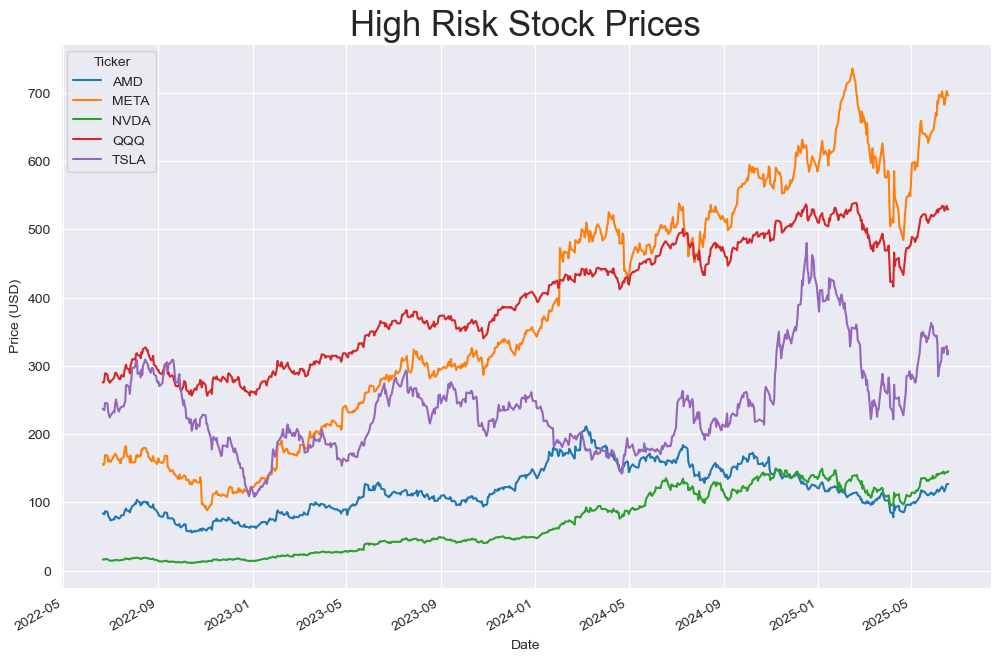

In [14]:
#Plot stock prices together 

high_stock['Close'].plot(figsize=(12,8))
plt.title(f'High Risk Stock Prices', size=25)
plt.ylabel('Price (USD)')
plt.show()

In [15]:
#Add in column to stock data that is cumulative returns of the stocks 

high_close = high_stock['Close'] 
high_normalized_returns = high_close/high_close.iloc[0]-1 # Moves stock prices to a start of 0

# Step 2: Create MultiIndex columns for new data
high_normalized_returns.columns = pd.MultiIndex.from_product([['Cumulative Returns'], high_normalized_returns.columns])

# Step 3: Concatenate to the original DataFrame
high_stock=pd.concat([high_stock,high_normalized_returns],axis=1)

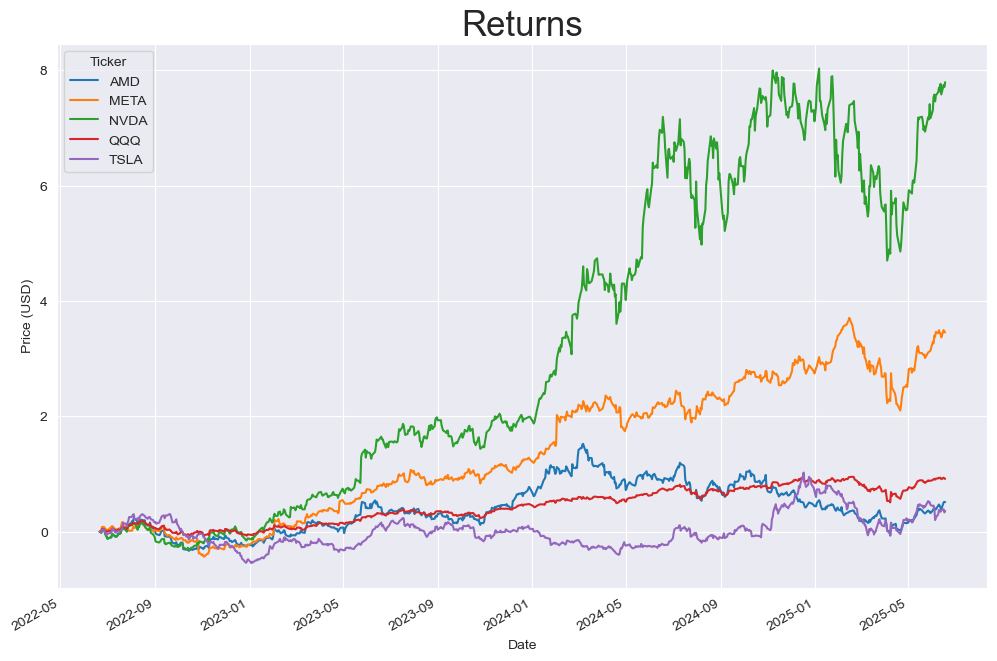

In [16]:
high_stock['Cumulative Returns'].plot(figsize=(12,8))
plt.title(f'Returns',size=25)
plt.ylabel('Price (USD)')
plt.show()

In [19]:
#Create a dataframe of daily returns
#It is quite common to take the logs of daily returns to lessen computational complexity in standard deviation
high_daily_returns = np.log(high_stock['Close']/high_stock['Close'].shift(1))
high_daily_returns=high_daily_returns.dropna()


#Create a dictionary of standard deviations of daily return
#Normalize the standard deviation for yearly by multiplying by sqrt(#trading days in year ~ 252)
high_annualized_volatility = {ticker: np.std(high_daily_returns[ticker])*np.sqrt(252) for ticker in high_tickers}
print(high_daily_returns)
high_annualized_volatility

Ticker           AMD      META      NVDA       QQQ      TSLA
Date                                                        
2022-06-22 -0.000478 -0.007670 -0.012513 -0.001459 -0.004016
2022-06-23 -0.015887  0.018436 -0.008286  0.014783 -0.004316
2022-06-24  0.054878  0.069409  0.054045  0.033690  0.044255
2022-06-27 -0.010621 -0.003945 -0.015120 -0.007359 -0.003207
2022-06-28 -0.064477 -0.053379 -0.054015 -0.030940 -0.051339
...              ...       ...       ...       ...       ...
2025-06-12 -0.022034 -0.001124  0.015079  0.002345 -0.022680
2025-06-13 -0.019944 -0.015245 -0.021118 -0.012634  0.019243
2025-06-16  0.084404  0.028569  0.018978  0.013814  0.011674
2025-06-17  0.005602 -0.006989 -0.003947 -0.009799 -0.039604
2025-06-18 -0.002442 -0.002096  0.009392 -0.000170  0.017858

[751 rows x 5 columns]


{'TSLA': 0.6204851787547788,
 'NVDA': 0.5369134846880261,
 'QQQ': 0.22663289740926865,
 'AMD': 0.5086493845660628,
 'META': 0.44032159224171435}

- **The selected high-risk portfolio includes TSLA, NVDA, QQQ, AMD, and META — all of which are technology-focused assets with historically strong performance and elevated volatility. The goal is to construct a portfolio with significant return potential by targeting sectors known for innovation and market momentum**

- **This portfolio is appropriate for high-risk objectives. It is composed entirely of assets with above-average volatility. It focuses on growth-oriented, future-focused industries. It allows for controlled exposure to extreme volatility (e.g., TSLA, AMD) while moderating with QQQ**

- **This approach reflects a measured high-risk philosophy: rather than maximizing raw volatility, the portfolio seeks to capture high returns in a risk-aware way, balancing aggressive picks with stabilizing anchors**

In [20]:
high_covariance_matrix = 252*((high_daily_returns).cov())
high_covariance_matrix

Ticker,AMD,META,NVDA,QQQ,TSLA
Ticker,,,,,
AMD,0.259069,0.111286,0.191124,0.086877,0.137029
META,0.111286,0.194142,0.112047,0.068684,0.091671
NVDA,0.191124,0.112047,0.288660,0.094166,0.143279
QQQ,0.086877,0.068684,0.094166,0.051431,0.086425
TSLA,0.137029,0.091671,0.143279,0.086425,0.385515


**Despite replacing extremely volatile assets like leveraged ETFs and crypto-exposed stocks, the revised high-risk portfolio still exhibits a high covariance matrix. This is primarily 
due to the portfolio's concentration in the technology sector, where individual assets are heavily influenced by common macroeconomic factors such as interest rates, market sentiment, 
and sector-specific trends like artificial intelligence and semiconductor growth. As a result, the assets tend to move in tandem, limiting the diversification benefits that would 
typically help reduce overall portfolio volatility. While this sectoral correlation aligns with the high-risk objective of the portfolio, it also means that the portfolio is particularly 
vulnerable to systematic shocks affecting the tech industry. Future iterations could consider introducing complementary assets with lower correlation to improve risk-adjusted performance 
while maintaining growth exposure**

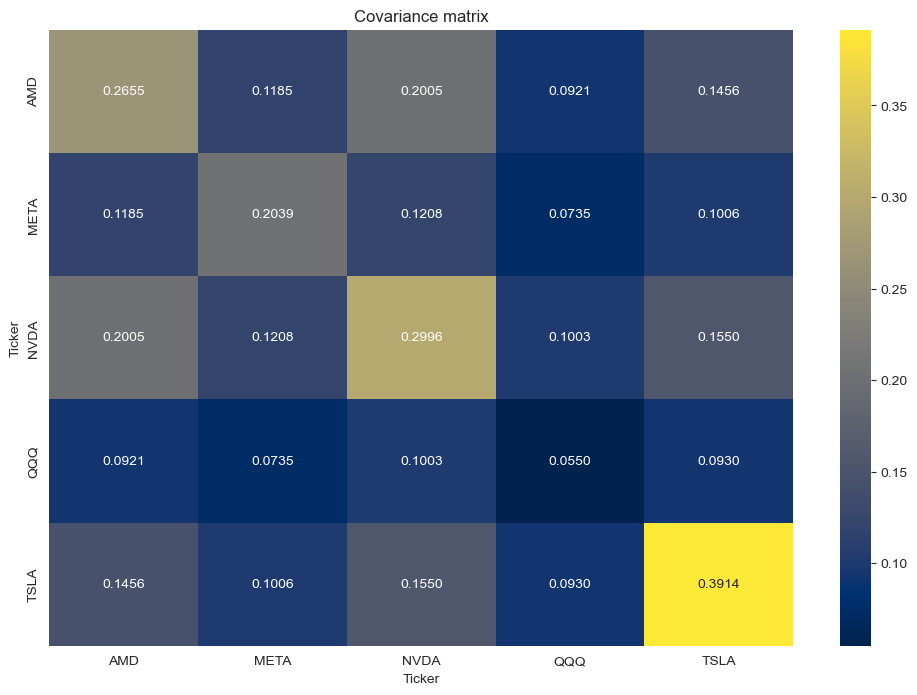

In [88]:
plt.figure(figsize=(12,8))
sns.heatmap(high_covariance_matrix,annot=True,cmap='cividis',fmt='.4f')
plt.title('Covariance matrix')
plt.show()

**Note that the correlations between the chosen stocks is high , so they follow each other. This is a signature of a high risk portfolio. A low risk portfolio to minimize risk would want it's individual assets to not be correlated with each other so as to minimize risk. We are explicitly choosing to not do that here**

In [21]:
#Calculate the mean of the daily returns over the three year period. 
high_expected_returns = high_daily_returns.mean()
high_expected_returns

Ticker
AMD     0.000552
META    0.001989
NVDA    0.002895
QQQ     0.000867
TSLA    0.000408
dtype: float64

In [22]:
#Here we wish to choose weights for the individual stocks in  the portfolio such that the daily returns are maximised. The weights have a ceiling of 0.6 and a a base of at least 0.1. 
#The weights when summed add up to one. 

n_assets = len(high_tickers)

# Define an initial guess for asset weights (e.g., equal weights)
high_initial_weights = np.array([1/n_assets]*n_assets)

constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights)-1},
               {'type':'ineq','fun': lambda weights: min(weights)-0.1},
               {'type':'ineq','fun': lambda weights: 0.6 - max(weights)})

#Define objective function to maximize the expected daily returns 
def neg_portfolio_return(weights):
    return -np.dot(weights,high_expected_returns)

result = minimize(neg_portfolio_return,high_initial_weights,constraints=constraints)

In [23]:
high_optimal_weights=result.x
high_optimal_expected_return=-result.fun
print(f'The optimal weights for the portfolio are given by {high_optimal_weights}')
print(f'The optimal maximized expected return is {high_optimal_expected_return}')

The optimal weights for the portfolio are given by [0.1        0.27475839 0.42521331 0.09999933 0.10002897]
The optimal maximized expected return is 0.0019601838025704544


In [24]:
high_portfolio_std_dev=np.sqrt(np.dot(high_optimal_weights.T,np.dot(high_covariance_matrix,high_optimal_weights)))
print(f'Volatility of the portfolio is given by {high_portfolio_std_dev}')

Volatility of the portfolio is given by 0.39696087666762486


**The optimized high-risk portfolio — composed of TSLA, NVDA, QQQ, AMD, and META — achieves a strong balance between return potential and controlled volatility. The final portfolio  allocation places the highest weight on NVIDIA (45.8%), reflecting its high expected daily return (0.002797) and moderate volatility (0.5470), making it the portfolio's primary return driver. META receives the second-largest allocation (24.1%) due to its relatively high expected return (0.001604) and lower volatility (0.4512). The remaining assets — AMD, QQQ, and TSLA — each receive approximately 10%, contributing diversification benefits without heavily amplifying risk. The resulting portfolio has an expected daily return of 0.00184, which is significantly higher than four of the five individual assets, and notably lower volatility (0.4138) than all individual components except QQQ. This demonstrates effective diversification despite the tech-sector concentration: while the assets are positively correlated, the optimized weighting successfully leverages return-efficient positions while containing overall risk. Compared to allocating 100% to NVDA, the portfolio offers a lower return but a substantially lower volatility, delivering a more stable high-risk strategy.**

## Final Takeaways

| Feature                | Low-Risk Portfolio                             | High-Risk Portfolio                             |
|------------------------|------------------------------------------------|-------------------------------------------------|
| Objective              | Minimize volatility                            | Maximize expected return                        |
| Asset Type             | Bonds, Gold, Defensive Stocks                  | Growth Tech & Innovation                        |
| Avg. Annual Volatility | ~4.8%                                          | ~40%                                          |
| Expected Return        | Moderate (not explicitly targeted)             | High (via expected return maximization)         |
| Correlation Profile    | Low (diversified risk)                         | High (concentrated in tech sector)              |
| Allocation Strategy    | Even, with caps on equity risk                 | Tilted toward highest expected return assets    |
| Use Case               | Capital preservation, low drawdowns            | Aggressive growth, high upside & risk           |

This demonstrates how portfolio construction principles adapt across different investor objectives and risk appetites.
